In [53]:
import torch
from torch import nn
import matplotlib.pyplot as plt 
import numpy as np

In [54]:
torch.cuda.is_available()
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev)

## Modelo proposto por Murray

Modelo proposto por Murray, por volta de 1990. Este modelo levou em conta que gliomas raramente realizam metastaze para fora do cérebro. A fim de simplificar a definição de cancer como uma proliferação desordenada de células e uma invasão local, ele assumiu que a difusão das células cancerígenas como o gradiente de acordo com a lei de Fick, expressando, posteriormente, de forma matemática através da seguinte relação

$$
\dfrac{\partial c}{\partial t} = \bigtriangledown \cdot (\bigtriangledown c) + pc 
$$

onde:
- $c(x,t)$: Concentração de células tumorais por mm³
- $D$: Coeficiente de difusão dado em mm²/dia (representa a mortalidade da célula)
- $p$: Taxa de proliferação em 1/dia

In [55]:
class NeuralNetwork(torch.nn.Module):

    def __init__(self, n_inputs: int, n_layers: int, n_neurons: int, n_output: int, act):
        super().__init__()

        self.n_inputs = n_inputs 
        self.n_layers = n_layers
        self.n_neurons = n_neurons

        layers = []

        layers.append( torch.nn.Linear(n_inputs, n_neurons))
        for i in range(n_layers): layers.extend( [torch.nn.Linear(n_neurons,n_neurons), act])
        layers.append(torch.nn.Linear(n_neurons, n_output))

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()    

In [56]:
#PARAMETROS
D = 0.0013
p = 0.12
L = 2.0
c0 = 8e4

Dl = D / (p * L**2)

#DOMINIO ESPACIAL E TEMPORAL
x_dom = (0, 1)
y_dom = (0, 1)
t_dom = (0, 20)

#ADIMENSIONALIZAÇÃO
batch_size = 100
x = torch.FloatTensor(batch_size).uniform_(x_dom[0], x_dom[1]).requires_grad_().to(device)
y = torch.FloatTensor(batch_size).uniform_(y_dom[0], y_dom[1]).requires_grad_().to(device)
t = torch.FloatTensor(batch_size).uniform_(t_dom[0], t_dom[1]).requires_grad_().to(device)


#DECLARAÇÃO DA EQUAÇÃO DIFERENCIAL
def DifusaoReacao(x, y, t, model):

    input = torch.stack((x, y, t),1)
    c = model(input)

    cl = (c * L**3) / c0

    c_t = torch.autograd.grad(cl.sum(), t, create_graph = True)[0]

    c_x = torch.autograd.grad(cl.sum(), x, create_graph = True)[0]
    c_xx = torch.autograd.grad(c_x.sum(), x, create_graph = True)[0]
    c_y = torch.autograd.grad(cl.sum(), y, create_graph = True)[0]
    c_yy = torch.autograd.grad(c_y.sum(), y, create_graph = True)[0]
    
    return c_t - (Dl * (c_xx + c_yy) - cl)

#VALORES DE ENTRADA
x0 = torch.tensor([L], dtype=torch.float32).to(device)
y0 = torch.tensor([L], dtype=torch.float32).to(device)
t0 = torch.tensor([0.], dtype=torch.float32).to(device)

#PREPARAÇÃO DOS DADOS

input_pde = torch.cartesian_prod(x, y, t).to(device)
input_ict = torch.cartesian_prod(x, y, t0).to(device)
input_icx = torch.cartesian_prod(x0, y, t).to(device)
input_icy = torch.cartesian_prod(x, y0, t).to(device)

input_bcx = torch.cartesian_prod(x, y0, t0).to(device)
input_bcy = torch.cartesian_prod(x0, y, t0).to(device)
bc_targetx = L**3 * torch.exp(-100 * x**2).to(device)
bc_targety = L**3 * torch.exp(-100 * y**2).to(device)

#DECLARAÇÃO DA ARQUITETURA USADA
model = NeuralNetwork(3, 1, 80, 1, torch.nn.Tanh()).to(device) # 1 input, 1 camada oculta, 20 neurônios/cam. oculta, 1 output, activação: Tanh

#PARAMETROS DO TREINAMENTO
epochs = 30000
optmizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-3,
)
loss_fn = torch.nn.MSELoss()

In [57]:
#TREINAMENTO
l_map = []

for ep in range(epochs):
    

    #CALCULO DO CUSTO PARA A CONDIÇÃO DE CONTORNO
    out_ic= model(input_bcx)
    l1 = loss_fn(out_ic, bc_targetx)

    out_ic= model(input_bcy)
    l2 = loss_fn(out_ic, bc_targety)

    out_ic= model(input_icy)
    ic_target2 = torch.zeros_like(out_ic)
    l3 = loss_fn(out_ic, ic_target2)

    out_ic= model(input_icx)
    ic_target3 = torch.zeros_like(out_ic)
    l4 = loss_fn(out_ic, ic_target3)

    #CALCULO DO CUSTO PARA A EDP
    out_pde= DifusaoReacao(x, y, t, model)
    pde_target = torch.zeros_like(out_pde)
    l5 = loss_fn(out_pde, pde_target)
    
    #BACKPROPAGATION
    loss = l1 + l2 + l3 + l4 + l5
    l_map.append(loss.item())

    loss.backward(retain_graph=True)
    optmizer.step()
    optmizer.zero_grad()

    with torch.autograd.no_grad():
        print(f'Epochs: {ep}/{epochs} Loss: {loss.item()}')
    
model.eval()

Epochs: 0/30000 Loss: 10.376740455627441
Epochs: 1/30000 Loss: 9.960155487060547
Epochs: 2/30000 Loss: 9.683675765991211
Epochs: 3/30000 Loss: 9.491610527038574
Epochs: 4/30000 Loss: 9.379647254943848
Epochs: 5/30000 Loss: 9.339012145996094
Epochs: 6/30000 Loss: 9.33664608001709
Epochs: 7/30000 Loss: 9.33784294128418
Epochs: 8/30000 Loss: 9.328322410583496
Epochs: 9/30000 Loss: 9.305366516113281
Epochs: 10/30000 Loss: 9.268980979919434
Epochs: 11/30000 Loss: 9.221631050109863
Epochs: 12/30000 Loss: 9.16859245300293
Epochs: 13/30000 Loss: 9.116052627563477
Epochs: 14/30000 Loss: 9.068804740905762
Epochs: 15/30000 Loss: 9.02902889251709
Epochs: 16/30000 Loss: 8.99651050567627
Epochs: 17/30000 Loss: 8.969675064086914
Epochs: 18/30000 Loss: 8.946492195129395
Epochs: 19/30000 Loss: 8.924789428710938
Epochs: 20/30000 Loss: 8.902314186096191
Epochs: 21/30000 Loss: 8.87708568572998
Epochs: 22/30000 Loss: 8.847968101501465
Epochs: 23/30000 Loss: 8.815047264099121
Epochs: 24/30000 Loss: 8.779420

NeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=80, bias=True)
    (2): Tanh()
    (3): Linear(in_features=80, out_features=1, bias=True)
  )
)

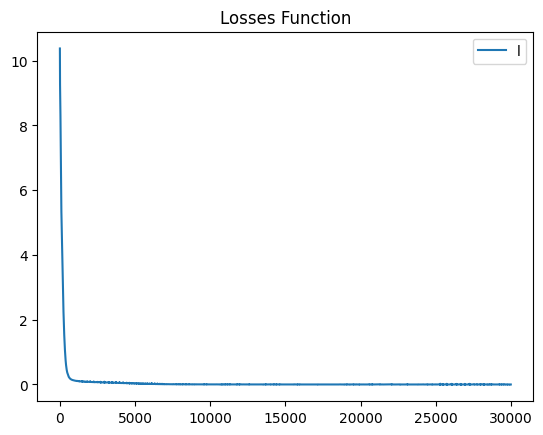

In [58]:
plt.plot(np.arange(0, epochs, 1), l_map, label = 'l')
plt.title('Losses Function')
plt.legend()
plt.show()

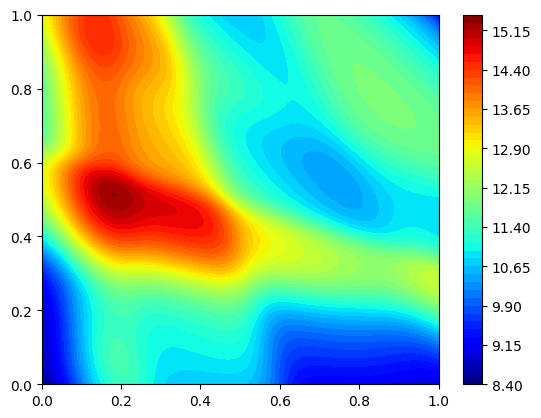

In [70]:
size = 1000
x_dom = (0, 1)
y_dom = (0, 1)

x = torch.linspace(x_dom[0], x_dom[1], size, dtype=torch.float32, requires_grad=True).to(device)
y = torch.linspace(y_dom[0], y_dom[1], size, dtype=torch.float32, requires_grad=True).to(device)
t = torch.tensor([0.]).to(device)

input = torch.cartesian_prod(x, y, t)
out = model(input)

x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()
t = t.cpu().detach().numpy()
out = out.cpu().detach().numpy()

X, Y = np.meshgrid(x, y)
out = np.reshape(out, (size, size)).T

plt.contourf(X, Y, out, levels = 50, cmap = 'jet')
plt.colorbar()
